## Hetereo Conv GNN

In [1]:
import torch
import random
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict
import networkx as nx
from torch_geometric.data import HeteroData

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42) 

# Parameters
NUM_USERS = 500
NUM_IPS = 200
NUM_EMAILS = 500
NUM_SESSIONS = 300
NUM_ADDRESSES = 400
NUM_CLAIMS = 1000
FRAUD_RATE = 0.2  # 10% claims are fraudulent
EVENT_TYPES = ['signup', 'login', 'send_code', 'account_change']
MAX_EVENTS_PER_CLAIM = 10
BFS_DEPTH = 2  # Depth for BFS

# Helper functions
def generate_timestamp(base_time, delta_minutes=60):
    return base_time + timedelta(minutes=random.randint(0, delta_minutes))

# Generate variable pools
user_ids = [f"user_{i}" for i in range(NUM_USERS)]
# Designate a subset of IPs and sessions for fraud
fraud_ips = [f"ip_{i}" for i in range(10)]  # 10 IPs dedicated to fraud
normal_ips = [f"ip_{i}" for i in range(10, NUM_IPS)]
ips = fraud_ips + normal_ips

fraud_sessions = [f"session_{i}" for i in range(10)]  # 10 sessions for fraud
normal_sessions = [f"session_{i}" for i in range(10, NUM_SESSIONS)]
sessions = fraud_sessions + normal_sessions

emails = [f"user_{i}@example.com" for i in range(NUM_EMAILS)]
addresses = [f"address_{i}" for i in range(NUM_ADDRESSES)]

# Generate claims
base_time = datetime.now()
claims = []
for claim_id in range(NUM_CLAIMS):
    is_fraud = 1 if random.random() < FRAUD_RATE else 0
    num_events = random.randint(1, MAX_EVENTS_PER_CLAIM)
    claim_events = []
    claim_time = generate_timestamp(base_time, delta_minutes=1440)  # within a day
    
    for event_num in range(num_events):
        event_type = random.choice(EVENT_TYPES)
        # Adjust timestamp for velocity
        if is_fraud:
            # Faster velocities: smaller delta
            timestamp = claim_time + timedelta(minutes=random.randint(0, 10))
        else:
            # Normal velocities
            timestamp = claim_time + timedelta(minutes=random.randint(0, 60))
        
        event = {
            'event_id': f"claim_{claim_id}_event_{event_num}",
            'claim_id': f"claim_{claim_id}",
            'event_type': event_type,
            'timestamp': timestamp,
            'user_id': random.choice(user_ids),
            'ip': random.choice(fraud_ips) if is_fraud and random.random() < 0.7 else random.choice(normal_ips),
            'email': random.choice(emails),
            'session': random.choice(fraud_sessions) if is_fraud and random.random() < 0.7 else random.choice(normal_sessions),
            'address': random.choice(addresses),
            'is_fraud': is_fraud
        }
        claim_events.append(event)
    claims.append({
        'claim_id': f"claim_{claim_id}",
        'is_fraud': is_fraud,
        'events': claim_events
    })

# Flatten all events
all_events = []
for claim in claims:
    all_events.extend(claim['events'])

# Create DataFrame for easy processing
events_df = pd.DataFrame(all_events)

# Sort events by timestamp for velocity calculations
events_df = events_df.sort_values('timestamp').reset_index(drop=True)

# Compute count-based features
count_features = {
    'user_id': events_df['user_id'].value_counts().to_dict(),
    'ip': events_df['ip'].value_counts().to_dict(),
    'email': events_df['email'].value_counts().to_dict(),
    'session': events_df['session'].value_counts().to_dict(),
    'address': events_df['address'].value_counts().to_dict(),
    'event_type': events_df['event_type'].value_counts().to_dict()
}

# Compute velocity-based features
velocity_features = defaultdict(list)
last_event_time_user = {}
last_event_time_session = {}

for idx, row in events_df.iterrows():
    user = row['user_id']
    session = row['session']
    current_time = row['timestamp']
    
    # Velocity for user
    if user in last_event_time_user:
        delta = (current_time - last_event_time_user[user]).total_seconds() / 60.0  # minutes
        velocity_features['user_velocity'].append(delta)
    else:
        velocity_features['user_velocity'].append(0.0)
    last_event_time_user[user] = current_time
    
    # Velocity for session
    if session in last_event_time_session:
        delta = (current_time - last_event_time_session[session]).total_seconds() / 60.0  # minutes
        velocity_features['session_velocity'].append(delta)
    else:
        velocity_features['session_velocity'].append(0.0)
    last_event_time_session[session] = current_time

# Assign velocity features
events_df['user_velocity'] = velocity_features['user_velocity']
events_df['session_velocity'] = velocity_features['session_velocity']

# Additional suspicious indicators
# For fraud, increase the number of 'account_change' and 'login' events
events_df['num_account_changes'] = events_df.groupby('user_id')['event_type'].transform(
    lambda x: (x == 'account_change').cumsum()
)
events_df['num_failed_logins'] = events_df.groupby('user_id')['event_type'].transform(
    lambda x: (x == 'login').cumsum()
)

# Introduce higher counts for fraudulent claims
# Amplify counts for fraud
events_df.loc[events_df['is_fraud'] == 1, 'num_account_changes'] += random.randint(1, 5)
events_df.loc[events_df['is_fraud'] == 1, 'num_failed_logins'] += random.randint(1, 5)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

le_event_type = LabelEncoder()
events_df['event_type_encoded'] = le_event_type.fit_transform(events_df['event_type'])

# Prepare HeteroData
data = HeteroData()

# Create node indices
event_ids = events_df['event_id'].unique()
user_id_ids = events_df['user_id'].unique()
ip_ids = events_df['ip'].unique()
email_ids = events_df['email'].unique()
session_ids = events_df['session'].unique()
address_ids = events_df['address'].unique()

# Mapping from ID to index
event_id_map = {eid: idx for idx, eid in enumerate(event_ids)}
user_id_map = {uid: idx for idx, uid in enumerate(user_id_ids)}
ip_map = {ip: idx for idx, ip in enumerate(ip_ids)}
email_map = {email: idx for idx, email in enumerate(email_ids)}
session_map = {sess: idx for idx, sess in enumerate(session_ids)}
address_map = {addr: idx for idx, addr in enumerate(address_ids)}

# Add event nodes with features
num_events = len(event_ids)
data['event'].num_nodes = num_events

# Features for event nodes
# Example features: event_type_encoded, user_velocity, session_velocity, num_account_changes, num_failed_logins
event_features = torch.tensor(
    events_df[['event_type_encoded', 'user_velocity', 'session_velocity', 'num_account_changes', 'num_failed_logins']].values,
    dtype=torch.float
)
data['event'].x = event_features

# Add other node types with dummy features (e.g., one-hot encoded)
# For simplicity, we'll use identity features
data['user_id'].num_nodes = len(user_id_ids)
data['user_id'].x = torch.eye(len(user_id_ids), dtype=torch.float)

data['ip'].num_nodes = len(ip_ids)
data['ip'].x = torch.eye(len(ip_ids), dtype=torch.float)

data['email'].num_nodes = len(email_ids)
data['email'].x = torch.eye(len(email_ids), dtype=torch.float)

data['session'].num_nodes = len(session_ids)
data['session'].x = torch.eye(len(session_ids), dtype=torch.float)

data['address'].num_nodes = len(address_ids)
data['address'].x = torch.eye(len(address_ids), dtype=torch.float)

# Create edge connections
# Define edge types: event to variable and variable to event (bidirectional)
edge_index_dict = {}

# event -> user_id
source = events_df['event_id'].map(event_id_map).values
target = events_df['user_id'].map(user_id_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_user_id', 'user_id')] = edge_index

# user_id -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('user_id', 'user_id_has', 'event')] = edge_index_rev

# event -> ip
source = events_df['event_id'].map(event_id_map).values
target = events_df['ip'].map(ip_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_ip', 'ip')] = edge_index

# ip -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('ip', 'ip_has', 'event')] = edge_index_rev

# event -> email
source = events_df['event_id'].map(event_id_map).values
target = events_df['email'].map(email_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_email', 'email')] = edge_index

# email -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('email', 'email_has', 'event')] = edge_index_rev

# event -> session
source = events_df['event_id'].map(event_id_map).values
target = events_df['session'].map(session_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_session', 'session')] = edge_index

# session -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('session', 'session_has', 'event')] = edge_index_rev

# event -> address
source = events_df['event_id'].map(event_id_map).values
target = events_df['address'].map(address_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_address', 'address')] = edge_index

# address -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('address', 'address_has', 'event')] = edge_index_rev

# Assign all edge indices to data
for key, edge in edge_index_dict.items():
    data[key[0], key[1], key[2]].edge_index = edge

# Create label for each claim
claim_labels = torch.tensor([claim['is_fraud'] for claim in claims], dtype=torch.long)

# Map claim_id to event_ids
claim_to_event = defaultdict(list)
for idx, row in events_df.iterrows():
    claim_to_event[row['claim_id']].append(event_id_map[row['event_id']])

# Assign label to all events of each claim
event_labels = torch.zeros(num_events, dtype=torch.long)
for claim_idx, claim in enumerate(claims):
    fraud_label = claim['is_fraud']
    for event_id in claim_to_event[claim['claim_id']]:
        event_labels[event_id] = fraud_label

data['event'].y = event_labels

# Save the data (optional)
# torch.save(data, 'fraud_detection_data_with_signals.pt')

print("Graph data generation with fraud signals completed.")
print(f"Number of event nodes: {data['event'].num_nodes}")
for node_type in data.node_types:
    print(f"Node type '{node_type}': {data[node_type].num_nodes} nodes")


Graph data generation with fraud signals completed.
Number of event nodes: 5508
Node type 'event': 5508 nodes
Node type 'user_id': 500 nodes
Node type 'ip': 200 nodes
Node type 'email': 500 nodes
Node type 'session': 300 nodes
Node type 'address': 400 nodes


C:\Users\nyihm\AppData\Local\Temp\ipykernel_186444\2134188108.py:209: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_index = torch.tensor([source, target], dtype=torch.long)


In [2]:
data

HeteroData(
  event={
    num_nodes=5508,
    x=[5508, 5],
    y=[5508],
  },
  user_id={
    num_nodes=500,
    x=[500, 500],
  },
  ip={
    num_nodes=200,
    x=[200, 200],
  },
  email={
    num_nodes=500,
    x=[500, 500],
  },
  session={
    num_nodes=300,
    x=[300, 300],
  },
  address={
    num_nodes=400,
    x=[400, 400],
  },
  (event, has_user_id, user_id)={ edge_index=[2, 5508] },
  (user_id, user_id_has, event)={ edge_index=[2, 5508] },
  (event, has_ip, ip)={ edge_index=[2, 5508] },
  (ip, ip_has, event)={ edge_index=[2, 5508] },
  (event, has_email, email)={ edge_index=[2, 5508] },
  (email, email_has, event)={ edge_index=[2, 5508] },
  (event, has_session, session)={ edge_index=[2, 5508] },
  (session, session_has, event)={ edge_index=[2, 5508] },
  (event, has_address, address)={ edge_index=[2, 5508] },
  (address, address_has, event)={ edge_index=[2, 5508] }
)

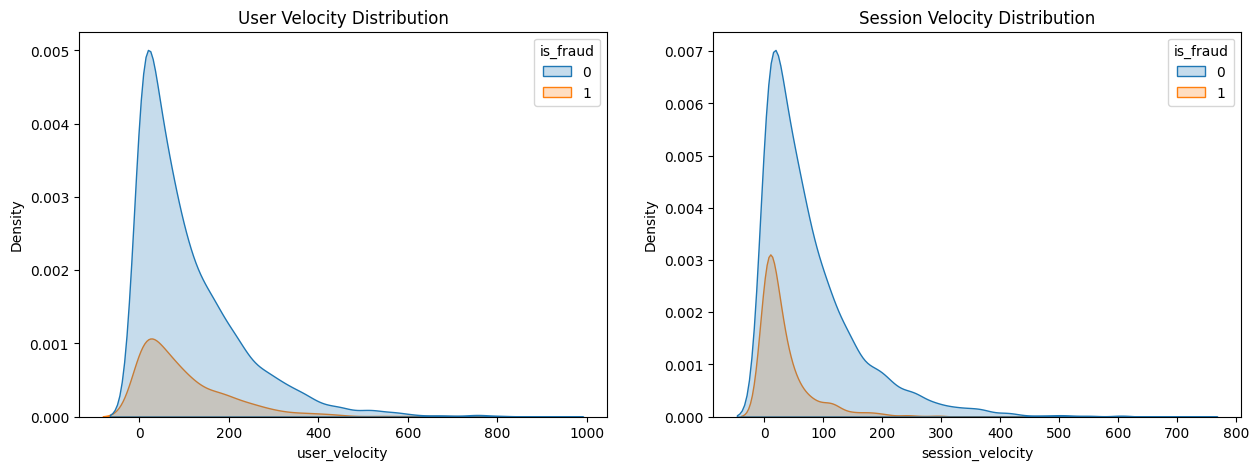

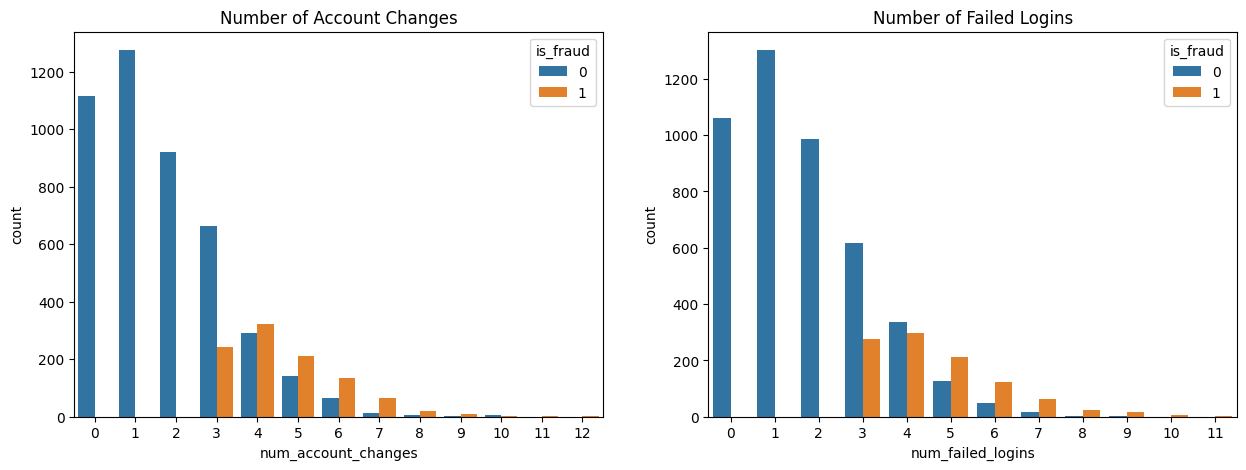

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert event labels to DataFrame
events_df['is_fraud'] = data['event'].y.numpy()

# Visualize distributions of key features
plt.figure(figsize=(15, 5))

# Velocity comparison
plt.subplot(1, 2, 1)
sns.kdeplot(data=events_df, x='user_velocity', hue='is_fraud', fill=True)
plt.title('User Velocity Distribution')

plt.subplot(1, 2, 2)
sns.kdeplot(data=events_df, x='session_velocity', hue='is_fraud', fill=True)
plt.title('Session Velocity Distribution')

plt.show()

# Count-based features comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=events_df, x='num_account_changes', hue='is_fraud')
plt.title('Number of Account Changes')

plt.subplot(1, 2, 2)
sns.countplot(data=events_df, x='num_failed_logins', hue='is_fraud')
plt.title('Number of Failed Logins')

plt.show()


In [9]:
# Block 2: Build the GNN Model Using Message Passing for Fraud Classification

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import HeteroConv, SAGEConv
from torch_geometric.data import HeteroData
from sklearn.metrics import accuracy_score, f1_score

# Assume data is already loaded from Block 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Calculate class weights
labels = data['event'].y
class_counts = torch.bincount(labels)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normalize weights
class_weights = class_weights.to(device)

# Define the GNN model
class FraudDetectionGNN(nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.conv2 = HeteroConv({
            edge_type: SAGEConv((-1, hidden_channels), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')

        # Linear layer for classification
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # First layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        
        # Second layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # For event nodes, get their embeddings
        event_embeddings = x_dict['event']

        # Classification
        out = self.lin(event_embeddings)
        return out

# Initialize the model
hidden_channels = 64
out_channels = 2  # Fraudulent or not
model = FraudDetectionGNN(hidden_channels, out_channels, data.metadata()).to(device)

# Define optimizer and loss with class weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Prepare data for training
num_events = data['event'].num_nodes
mask = torch.rand(num_events, device=device) < 0.8  # 80% train, 20% test
train_mask = mask
test_mask = ~mask

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = criterion(out[train_mask], data['event'].y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1)
    train_acc = accuracy_score(data['event'].y[train_mask].cpu(), pred[train_mask].cpu())
    test_acc = accuracy_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())
    test_f1 = f1_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())
    return train_acc, test_acc, test_f1

# Training the model
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        train_acc, test_acc, test_f1 = test()
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")

print("Training completed.")


Epoch: 010, Loss: 3.0242, Train Acc: 0.8446, Test Acc: 0.8392, Test F1: 0.3218
Epoch: 020, Loss: 0.9673, Train Acc: 0.7179, Test Acc: 0.7121, Test F1: 0.5247
Epoch: 030, Loss: 0.4230, Train Acc: 0.7840, Test Acc: 0.7929, Test F1: 0.6225
Epoch: 040, Loss: 0.2693, Train Acc: 0.9192, Test Acc: 0.9292, Test F1: 0.8211
Epoch: 050, Loss: 0.1591, Train Acc: 0.9621, Test Acc: 0.9637, Test F1: 0.9024
Epoch: 060, Loss: 0.1208, Train Acc: 0.9651, Test Acc: 0.9664, Test F1: 0.9129
Epoch: 070, Loss: 0.1052, Train Acc: 0.9646, Test Acc: 0.9655, Test F1: 0.9128
Epoch: 080, Loss: 0.0939, Train Acc: 0.9696, Test Acc: 0.9700, Test F1: 0.9224
Epoch: 090, Loss: 0.0882, Train Acc: 0.9676, Test Acc: 0.9646, Test F1: 0.9108
Epoch: 100, Loss: 0.0817, Train Acc: 0.9682, Test Acc: 0.9646, Test F1: 0.9108
Training completed.


Label Distribution: {0: 4493, 1: 1015}


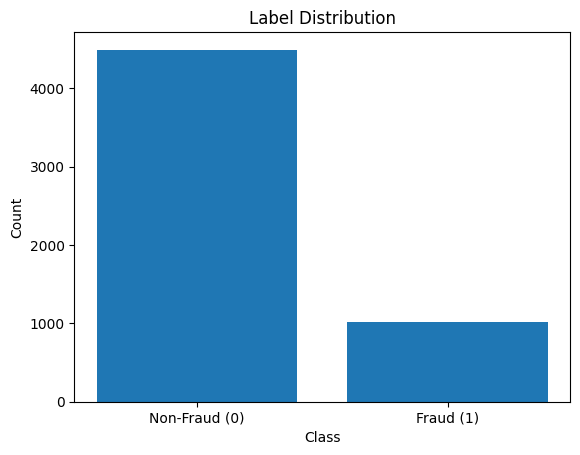

In [6]:
# After Block 1: Data Generation with Fraud Signals

# Calculate label distribution
labels = data['event'].y.cpu().numpy()
unique, counts = np.unique(labels, return_counts=True)
label_distribution = dict(zip(unique, counts))
print(f"Label Distribution: {label_distribution}")

# Visualize label distribution
import matplotlib.pyplot as plt

plt.bar(['Non-Fraud (0)', 'Fraud (1)'], [label_distribution.get(0, 0), label_distribution.get(1, 0)])
plt.title('Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


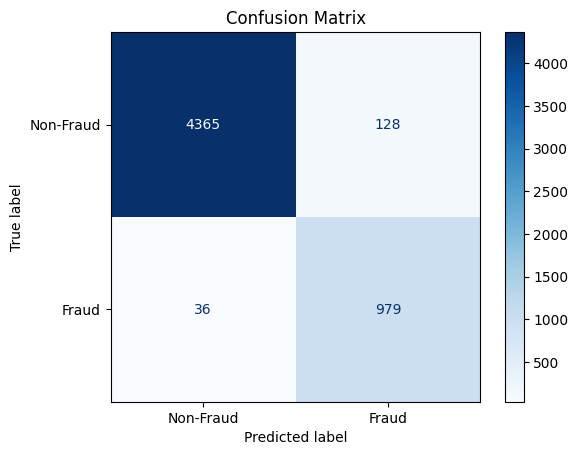

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# After training loop

# Final predictions
model.eval()
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1).cpu().numpy()
    labels = data['event'].y.cpu().numpy()

# Confusion Matrix
cm = confusion_matrix(labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


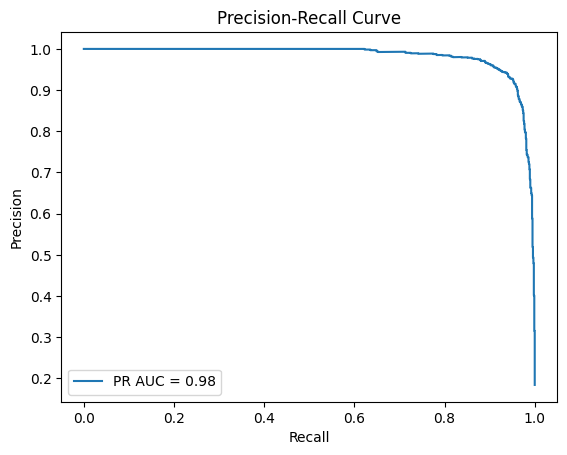

In [8]:
from sklearn.metrics import precision_recall_curve, auc

# Compute probabilities
with torch.no_grad():
    probabilities = F.softmax(out, dim=1)[:, 1].cpu().numpy()

precision, recall, _ = precision_recall_curve(labels, probabilities)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


## v2

In [20]:
import torch
import random
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict
from torch_geometric.data import HeteroData

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define constants
NUM_USERS, NUM_IPS, NUM_EMAILS = 500, 200, 500
NUM_SESSIONS, NUM_ADDRESSES, NUM_CLAIMS = 300, 400, 1000
FRAUD_RATE, MAX_EVENTS_PER_CLAIM = 0.2, 10

# Helper function to generate random timestamps
def generate_timestamp(base_time, delta_minutes):
    return base_time + timedelta(minutes=random.randint(0, delta_minutes))

# Variables
user_ids = [f"user_{i}" for i in range(NUM_USERS)]
ips = [f"ip_{i}" for i in range(NUM_IPS)]
emails = [f"user_{i}@example.com" for i in range(NUM_EMAILS)]
sessions = [f"session_{i}" for i in range(NUM_SESSIONS)]
addresses = [f"address_{i}" for i in range(NUM_ADDRESSES)]

fraud_ips = ips[:10]
fraud_sessions = sessions[:10]
base_time = datetime.now()

# Generate events and claims
claims, all_events = [], []
for claim_id in range(NUM_CLAIMS):
    is_fraud = random.random() < FRAUD_RATE
    claim_time = generate_timestamp(base_time, 1440)  # within a day
    num_events = random.randint(1, MAX_EVENTS_PER_CLAIM)

    claim_events = []
    for event_num in range(num_events):
        timestamp = generate_timestamp(claim_time, 10 if is_fraud else 60)
        event = {
            'event_id': f"claim_{claim_id}_event_{event_num}",
            'claim_id': f"claim_{claim_id}",
            'event_type': random.choice(['signup', 'login', 'send_code', 'account_change']),
            'timestamp': timestamp,
            'user_id': random.choice(user_ids),
            'ip': random.choice(fraud_ips if is_fraud and random.random() < 0.7 else ips),
            'email': random.choice(emails),
            'session': random.choice(fraud_sessions if is_fraud and random.random() < 0.7 else sessions),
            'address': random.choice(addresses),
            'is_fraud': is_fraud
        }
        claim_events.append(event)

    claims.append({'claim_id': f"claim_{claim_id}", 'is_fraud': is_fraud, 'events': claim_events})
    all_events.extend(claim_events)

# Create dataframe for easy manipulation
events_df = pd.DataFrame(all_events).sort_values('timestamp').reset_index(drop=True)

# Calculate count-based features for graph nodes (e.g., degree, event frequency)
count_features = {col: events_df[col].value_counts().to_dict() for col in ['user_id', 'ip', 'email', 'session', 'address']}

# Velocity features (time between events per user/session)
velocity_features = defaultdict(list)
last_event_time_user, last_event_time_session = {}, {}

for idx, row in events_df.iterrows():
    for entity, last_event_time, feature in [('user_id', last_event_time_user, 'user_velocity'),
                                             ('session', last_event_time_session, 'session_velocity')]:
        if row[entity] in last_event_time:
            delta = (row['timestamp'] - last_event_time[row[entity]]).total_seconds() / 60.0
            velocity_features[feature].append(delta)
        else:
            velocity_features[feature].append(0.0)
        last_event_time[row[entity]] = row['timestamp']

# Add velocity features to dataframe
for feature in velocity_features:
    events_df[feature] = velocity_features[feature]

# Assign suspicious indicators (for fraud amplification)
events_df['num_account_changes'] = events_df.groupby('user_id')['event_type'].transform(lambda x: (x == 'account_change').cumsum())
events_df['num_failed_logins'] = events_df.groupby('user_id')['event_type'].transform(lambda x: (x == 'login').cumsum())

# Adjust for fraud
fraud_adjustments = events_df['is_fraud'] == 1
events_df.loc[fraud_adjustments, 'num_account_changes'] += random.randint(1, 5)
events_df.loc[fraud_adjustments, 'num_failed_logins'] += random.randint(1, 5)

# Encode event types for graph features
from sklearn.preprocessing import LabelEncoder
le_event_type = LabelEncoder()
events_df['event_type_encoded'] = le_event_type.fit_transform(events_df['event_type'])

# Create the graph in HeteroData format
data = HeteroData()

# Create nodes with one-hot encoded features
node_types = ['user_id', 'ip', 'email', 'session', 'address']
for node_type in node_types:
    unique_ids = events_df[node_type].unique()
    data[node_type].x = torch.eye(len(unique_ids), dtype=torch.float)
    data[node_type].num_nodes = len(unique_ids)

# Assign event node features
data['event'].num_nodes = len(events_df)
data['event'].x = torch.tensor(events_df[['event_type_encoded', 'user_velocity', 'session_velocity', 'num_account_changes', 'num_failed_logins']].values, dtype=torch.float)

# Map claim labels to event nodes
event_labels = torch.tensor(events_df['is_fraud'].values, dtype=torch.long)
data['event'].y = event_labels

# Define edges
edge_index_dict = {}
for source, target in [('event', 'user_id'), ('event', 'ip'), ('event', 'email'), ('event', 'session'), ('event', 'address')]:
    source_idx = events_df['event_id'].map({eid: idx for idx, eid in enumerate(events_df['event_id'].unique())}).values
    target_idx = events_df[target].map({tid: idx for idx, tid in enumerate(events_df[target].unique())}).values
    edge_index_dict[(source, f"has_{target}", target)] = torch.tensor([source_idx, target_idx], dtype=torch.long)
    edge_index_dict[(target, f"{target}_has", source)] = torch.tensor([target_idx, source_idx], dtype=torch.long)

for edge_type, edge_index in edge_index_dict.items():
    data[edge_type[0], edge_type[1], edge_type[2]].edge_index = edge_index

print("Graph data generation completed with fraud signals.")


Graph data generation completed with fraud signals.


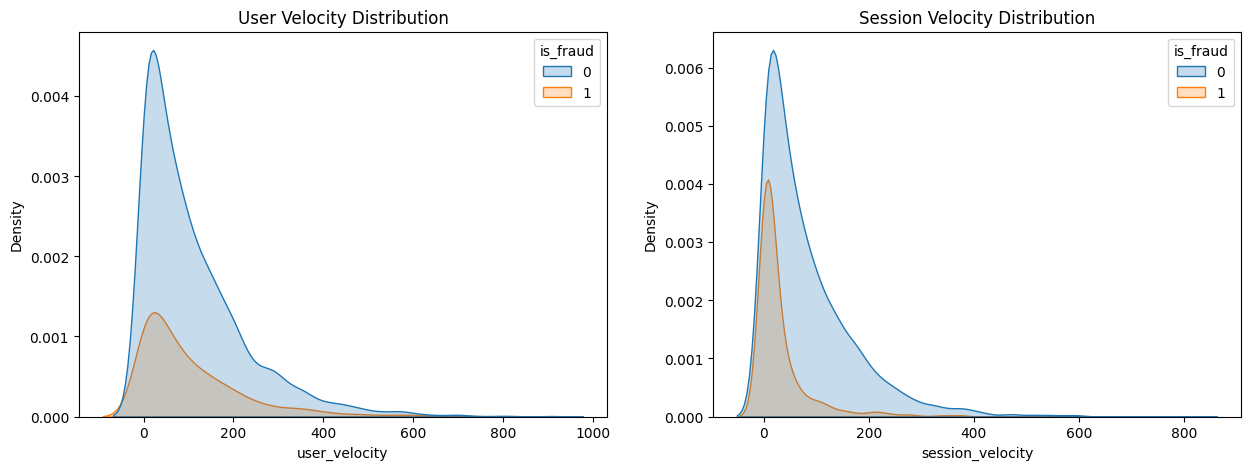

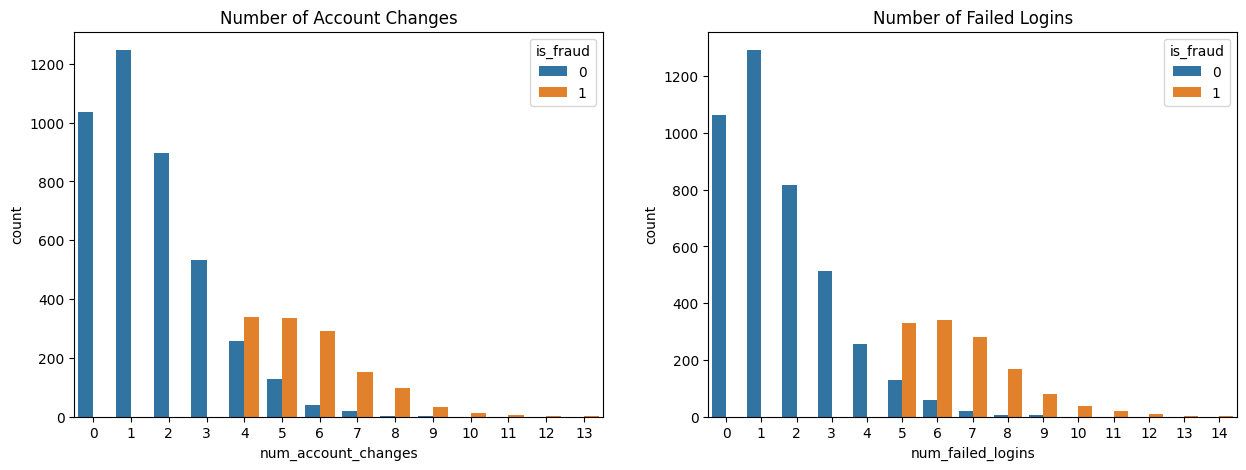

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert event labels to DataFrame
events_df['is_fraud'] = data['event'].y.numpy()

# Visualize distributions of key features
plt.figure(figsize=(15, 5))

# Velocity comparison
plt.subplot(1, 2, 1)
sns.kdeplot(data=events_df, x='user_velocity', hue='is_fraud', fill=True)
plt.title('User Velocity Distribution')

plt.subplot(1, 2, 2)
sns.kdeplot(data=events_df, x='session_velocity', hue='is_fraud', fill=True)
plt.title('Session Velocity Distribution')

plt.show()

# Count-based features comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=events_df, x='num_account_changes', hue='is_fraud')
plt.title('Number of Account Changes')

plt.subplot(1, 2, 2)
sns.countplot(data=events_df, x='num_failed_logins', hue='is_fraud')
plt.title('Number of Failed Logins')

plt.show()


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv
from torch_geometric.loader import NeighborLoader
from sklearn.metrics import accuracy_score, f1_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Compute class weights for imbalanced dataset
labels = data['event'].y
class_weights = 1.0 / torch.bincount(labels).float()
class_weights = class_weights.to(device)

# Define the GNN model for fraud detection
class FraudDetectionGNN(nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')
        self.conv2 = HeteroConv({
            edge_type: SAGEConv((-1, hidden_channels), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['event'])

# Model initialization
hidden_channels, out_channels = 64, 2
model = FraudDetectionGNN(hidden_channels, out_channels, data.metadata()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train/test mask setup
num_events = data['event'].num_nodes
mask = torch.rand(num_events, device=device) < 0.8  # 80% train, 20% test
train_mask, test_mask = mask, ~mask

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = criterion(out[train_mask], data['event'].y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1)
    train_acc = accuracy_score(data['event'].y[train_mask].cpu(), pred[train_mask].cpu())
    test_acc = accuracy_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())
    test_f1 = f1_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())
    return train_acc, test_acc, test_f1

# Training loop execution
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        train_acc, test_acc, test_f1 = test()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, F1: {test_f1:.4f}")


Epoch 010, Loss: 4.9797, Train Acc: 0.2358, Test Acc: 0.2264, F1: 0.3693
Epoch 020, Loss: 0.9274, Train Acc: 0.8317, Test Acc: 0.8185, F1: 0.5249
Epoch 030, Loss: 0.5544, Train Acc: 0.8411, Test Acc: 0.8315, F1: 0.6655
Epoch 040, Loss: 0.2614, Train Acc: 0.9302, Test Acc: 0.9162, F1: 0.8307
Epoch 050, Loss: 0.1304, Train Acc: 0.9674, Test Acc: 0.9585, F1: 0.9124
Epoch 060, Loss: 0.0650, Train Acc: 0.9798, Test Acc: 0.9732, F1: 0.9433
Epoch 070, Loss: 0.0411, Train Acc: 0.9862, Test Acc: 0.9767, F1: 0.9503
Epoch 080, Loss: 0.0315, Train Acc: 0.9883, Test Acc: 0.9758, F1: 0.9483
Epoch 090, Loss: 0.0264, Train Acc: 0.9899, Test Acc: 0.9767, F1: 0.9499
Epoch 100, Loss: 0.0225, Train Acc: 0.9852, Test Acc: 0.9723, F1: 0.9420


## Edgelist Injection

In [31]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv, GATConv, Linear, to_hetero
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader
from sklearn.model_selection import train_test_split

# Sample DataFrame (Replace this with your actual data loading)
# Columns: [node1, node1_type, node2, node2_type, business_event, business_event_type, timestamp]
data = {
    'node1': ['A', 'A', 'B', 'C'],
    'node1_type': ['Person', 'Person', 'Company', 'Person'],
    'node2': ['B', 'C', 'C', 'D'],
    'node2_type': ['Company', 'Person', 'Person', 'Company'],
    'business_event': ['E1', 'E2', 'E1', 'E3'],
    'business_event_type': ['Sale', 'Purchase', 'Sale', 'Sale'],
    'timestamp': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04']
}
df = pd.DataFrame(data)

# Function to construct the heterogeneous graph
def construct_hetero_graph(df, include_business_event=False, link_business_events=False):
    hetero_data = HeteroData()

    # Collect all unique nodes per type
    node_types = set(df['node1_type']).union(set(df['node2_type']))
    if include_business_event:
        node_types = node_types.union(set(df['business_event_type']))

    # Create mapping from node identifier to unique integer index per node type
    node_id_maps = {}
    for ntype in node_types:
        if ntype in df['business_event_type'].unique():  # business_event_type column for events
            identifiers = df[df['business_event_type'] == ntype]['business_event'].unique()
        else:
            identifiers = pd.concat([
                df[df['node1_type'] == ntype]['node1'],
                df[df['node2_type'] == ntype]['node2']
            ]).unique()
        node_id_maps[ntype] = {name: idx for idx, name in enumerate(identifiers)}
        hetero_data[ntype].num_nodes = len(node_id_maps[ntype])
        # Initialize node features (to be filled later)
        hetero_data[ntype].x = torch.ones((len(node_id_maps[ntype]), 1))  # Placeholder

    edge_dict = {}

    # Define edge types dynamically based on actual node types
    relations = set()
    for _, row in df.iterrows():
        relations.add((row['node1_type'], 'related_to', row['node2_type']))
        relations.add((row['node2_type'], 'related_to', row['node1_type']))

    # Add relations involving business_event if included
    if include_business_event:
        for _, row in df.iterrows():
            relations.add((row['node1_type'], 'participates_in', row['business_event_type']))
            relations.add((row['business_event_type'], 'has_participant', row['node1_type']))
            relations.add((row['node2_type'], 'participates_in', row['business_event_type']))
            relations.add((row['business_event_type'], 'has_participant', row['node2_type']))

    # Initialize edge indices for all relation types
    for rel in relations:
        edge_dict[rel] = [[], []]

    # Populate edge indices
    for _, row in df.iterrows():
        n1 = row['node1']
        n1_type = row['node1_type']
        n2 = row['node2']
        n2_type = row['node2_type']

        # Add edge between node1 and node2
        edge_dict[(n1_type, 'related_to', n2_type)][0].append(node_id_maps[n1_type][n1])
        edge_dict[(n1_type, 'related_to', n2_type)][1].append(node_id_maps[n2_type][n2])

        # If business_event is included, add edges between nodes and business_event
        if include_business_event:
            be = row['business_event']
            be_type = row['business_event_type']
            edge_dict[(n1_type, 'participates_in', be_type)][0].append(node_id_maps[n1_type][n1])
            edge_dict[(n1_type, 'participates_in', be_type)][1].append(node_id_maps[be_type][be])

            edge_dict[(be_type, 'has_participant', n1_type)][0].append(node_id_maps[be_type][be])
            edge_dict[(be_type, 'has_participant', n1_type)][1].append(node_id_maps[n1_type][n1])

            edge_dict[(n2_type, 'participates_in', be_type)][0].append(node_id_maps[n2_type][n2])
            edge_dict[(n2_type, 'participates_in', be_type)][1].append(node_id_maps[be_type][be])

            edge_dict[(be_type, 'has_participant', n2_type)][0].append(node_id_maps[be_type][be])
            edge_dict[(be_type, 'has_participant', n2_type)][1].append(node_id_maps[n2_type][n2])

    # If linking business_events that share any nodes
    if include_business_event and link_business_events:
        # For each business_event, find business_events that share any participant
        be_groups = df.groupby('business_event').agg({
            'node1': lambda x: set(x),
            'node2': lambda x: set(x)
        })

        # Combine node1 and node2 participants into a single set
        be_participants = be_groups.apply(lambda row: row['node1'].union(row['node2']), axis=1)
        be_list = be_groups.index.tolist()

        # Create a dictionary of business event to participants
        be_participants_dict = {be: be_participants[be] for be in be_list}

        for i in range(len(be_list)):
            for j in range(i + 1, len(be_list)):
                be1 = be_list[i]
                be2 = be_list[j]
                if be_participants_dict[be1].intersection(be_participants_dict[be2]):
                    # Dynamically assign the business event type for linking
                    be_type1 = df[df['business_event'] == be1]['business_event_type'].iloc[0]
                    be_type2 = df[df['business_event'] == be2]['business_event_type'].iloc[0]

                    # Ensure the edge type (be_type, 'related_to', be_type) exists in the edge_dict
                    if (be_type1, 'related_to', be_type2) not in edge_dict:
                        edge_dict[(be_type1, 'related_to', be_type2)] = [[], []]

                    # Add edge between be1 and be2
                    edge_dict[(be_type1, 'related_to', be_type2)][0].append(node_id_maps[be_type1][be1])
                    edge_dict[(be_type1, 'related_to', be_type2)][1].append(node_id_maps[be_type2][be2])

    # Assign edge indices to hetero_data, ensuring both node types exist
    for rel, (src, dst) in tqdm(edge_dict.items()):
        src_type, _, dst_type = rel  # Unpack the relation tuple
        if src_type in hetero_data.node_types and dst_type in hetero_data.node_types:
            if len(src) > 0 and len(dst) > 0:
                hetero_data[(src_type, 'related_to', dst_type)].edge_index = torch.tensor([src, dst], dtype=torch.long)

    return hetero_data


# Construct graphs with different options
# Option 1: Exclude business_event as nodes
hetero_data1 = construct_hetero_graph(df, include_business_event=False, link_business_events=False)

# Option 2: Include business_event as nodes
hetero_data2 = construct_hetero_graph(df, include_business_event=True, link_business_events=False)

# Option 3: Include business_event as nodes and link them if they share any nodes
hetero_data3 = construct_hetero_graph(df, include_business_event=True, link_business_events=True)

# Example: Using hetero_data3 for modeling
data = hetero_data3

# Assume we are classifying nodes of type 'Person'
# For demonstration, let's create dummy labels
# Replace this with your actual labels
num_person = data['Person'].num_nodes
labels = torch.randint(0, 2, (num_person,))  # Binary classification
data['Person'].y = labels

# Split into train and test
train_mask, test_mask = train_test_split(range(num_person), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)
data['Person'].train_mask = torch.zeros(num_person, dtype=torch.bool)
data['Person'].train_mask[train_mask] = True
data['Person'].test_mask = torch.zeros(num_person, dtype=torch.bool)
data['Person'].test_mask[test_mask] = True

# Define the model
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # Define initial linear transformation for each node type
        self.lin_dict = torch.nn.ModuleDict({
            node_type: Linear(data[node_type].x.size(-1), hidden_channels)
            for node_type in data.node_types
        })

        # Define HeteroConv layer
        self.conv1 = HeteroConv({
            edge_type: SAGEConv(-1, hidden_channels)
            for edge_type in data.edge_types
        }, aggr='mean')

        self.conv2 = HeteroConv({
            edge_type: SAGEConv(hidden_channels, hidden_channels)
            for edge_type in data.edge_types
        }, aggr='mean')

        # Final linear layer for each node type
        self.lin_final = torch.nn.ModuleDict({
            node_type: Linear(hidden_channels, out_channels)
            for node_type in data.node_types
        })

    def forward(self, x_dict, edge_index_dict):
        # Initial transformation
        x_dict = {
            node_type: F.relu(self.lin_dict[node_type](x))
            for node_type, x in x_dict.items()
        }

        # First convolution
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}

        # Second convolution
        x_dict = self.conv2(x_dict, edge_index_dict)

        # Final transformation
        out = {
            node_type: self.lin_final[node_type](x)
            for node_type, x in x_dict.items()
        }

        return out

# Initialize the model
model = HeteroGNN(hidden_channels=16, out_channels=2)  # Binary classification

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Move data to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

# Training Loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    # Only compute loss for 'Person' nodes with train_mask
    person_out = out['Person'][data['Person'].train_mask]
    person_labels = data['Person'].y[data['Person'].train_mask]
    loss = criterion(person_out, person_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    person_out = out['Person']
    preds = person_out.argmax(dim=1)
    # Compute accuracy on test_mask
    correct = preds[data['Person'].test_mask] == data['Person'].y[data['Person'].test_mask]
    acc = int(correct.sum()) / int(data['Person'].test_mask.sum())
    return acc

# Example training
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')



Epoch: 020, Loss: 0.0000, Test Acc: 0.0000
Epoch: 040, Loss: 0.0000, Test Acc: 0.0000
Epoch: 060, Loss: 0.0000, Test Acc: 0.0000
Epoch: 080, Loss: 0.0000, Test Acc: 0.0000
Epoch: 100, Loss: 0.0000, Test Acc: 0.0000
Epoch: 120, Loss: 0.0000, Test Acc: 0.0000
Epoch: 140, Loss: 0.0000, Test Acc: 0.0000
Epoch: 160, Loss: 0.0000, Test Acc: 0.0000
Epoch: 180, Loss: 0.0000, Test Acc: 0.0000
Epoch: 200, Loss: 0.0000, Test Acc: 0.0000


In [6]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import (
    HeteroConv,
    SAGEConv,
    GATConv,
    Linear,
    to_hetero,
    GCNConv
)
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader, ClusterData, ClusterLoader, LinkNeighborLoader
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm  # Import tqdm for progress bars
import itertools

# -----------------------------
# 1. Synthetic Data Generation
# -----------------------------

def generate_synthetic_data(num_nodes_per_type, event_types, num_events, seed=42):
    """
    Generates synthetic graph data with specified node types and business event types.

    Parameters:
        num_nodes_per_type (dict): Number of nodes for each node type.
        event_types (list): List of business event types.
        num_events (int): Number of business events to generate.
        seed (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Synthetic edge list DataFrame.
    """
    np.random.seed(seed)
    random.seed(seed)
    
    nodes = {}
    for node_type, num in num_nodes_per_type.items():
        nodes[node_type] = [f'{node_type}_{i}' for i in range(num)]
    
    events = []
    for i in tqdm(range(num_events), desc="Generating Synthetic Events"):
        node1_type = random.choice(list(num_nodes_per_type.keys()))
        node2_type = random.choice(list(num_nodes_per_type.keys()))
        node1 = random.choice(nodes[node1_type])
        node2 = random.choice(nodes[node2_type])
        event_type = random.choice(event_types)
        event_id = f'E{i}'
        timestamp = pd.Timestamp('2023-01-01') + pd.Timedelta(days=random.randint(0, 365))
        events.append({
            'node1': node1,
            'node1_type': node1_type,
            'node2': node2,
            'node2_type': node2_type,
            'business_event': event_id,
            'business_event_type': event_type,
            'timestamp': timestamp
        })
    
    df = pd.DataFrame(events)
    return df

# ---------------------------------
# 2. Optimized Heterogeneous Graph Construction with Progress Bars
# ---------------------------------

def construct_hetero_graph(df, include_business_event=False, link_business_events=False):
    """
    Constructs a HeteroData graph from the edge list DataFrame with options to include business events.

    Parameters:
        df (pd.DataFrame): Edge list DataFrame.
        include_business_event (bool): Whether to include business events as nodes.
        link_business_events (bool): Whether to link business events that share any participants.

    Returns:
        HeteroData: Constructed heterogeneous graph.
    """
    hetero_data = HeteroData()

    # Collect all unique node types
    node_types = set(df['node1_type']).union(set(df['node2_type']))
    if include_business_event:
        node_types = node_types.union(set(df['business_event_type']))
    
    # Create node ID mappings in a vectorized manner
    node_id_maps = {}
    for ntype in tqdm(node_types, desc="Mapping Node IDs"):
        if include_business_event and ntype in df['business_event_type'].unique():
            identifiers = df.loc[df['business_event_type'] == ntype, 'business_event'].unique()
        else:
            identifiers = pd.concat([df.loc[df['node1_type'] == ntype, 'node1'], 
                                     df.loc[df['node2_type'] == ntype, 'node2']]).unique()
        
        # Use factorize to quickly map identifiers to unique integer indices
        unique_ids, _ = pd.factorize(identifiers)
        node_id_maps[ntype] = pd.Series(data=unique_ids, index=identifiers)
        hetero_data[ntype].num_nodes = len(node_id_maps[ntype])
        hetero_data[ntype].x = torch.ones((len(node_id_maps[ntype]), 1))  # Placeholder features

    # Map node identifiers to integer indices using vectorized operations
    tqdm.pandas(desc="Mapping Node IDs to Indices")
    df['node1_id'] = df.progress_apply(lambda row: node_id_maps[row['node1_type']][row['node1']], axis=1)
    df['node2_id'] = df.progress_apply(lambda row: node_id_maps[row['node2_type']][row['node2']], axis=1)

    # Initialize edge dictionary
    edge_dict = {}

    # Create edge indices for 'related_to' relations
    unique_relations = df[['node1_type', 'node2_type']].drop_duplicates()
    for rel in tqdm(unique_relations.itertuples(index=False), total=unique_relations.shape[0], desc="Creating Related_To Edges"):
        node1_type, node2_type = rel
        mask = (df['node1_type'] == node1_type) & (df['node2_type'] == node2_type)
        src_ids = df.loc[mask, 'node1_id'].values
        dst_ids = df.loc[mask, 'node2_id'].values
        if len(src_ids) == 0:
            continue
        edge_index = torch.tensor([src_ids, dst_ids], dtype=torch.long)
        edge_dict[(node1_type, 'related_to', node2_type)] = edge_index

        # Add reverse relation (node2 -> node1)
        edge_index_reverse = torch.tensor([dst_ids, src_ids], dtype=torch.long)
        edge_dict[(node2_type, 'related_to', node1_type)] = edge_index_reverse

    # If including business events, add corresponding relations
    if include_business_event:
        # Map business_event to unique integer IDs
        tqdm.pandas(desc="Mapping Business Event IDs")
        df['business_event_id'] = df.progress_apply(
            lambda row: node_id_maps[row['business_event_type']][row['business_event']], axis=1
        )
        
        # Create 'participates_in' and 'has_participant' edges for node1
        unique_relations_node1 = df[['node1_type', 'business_event_type']].drop_duplicates()
        for rel in tqdm(unique_relations_node1.itertuples(index=False), total=unique_relations_node1.shape[0], desc="Creating Participates_In Edges (node1)"):
            node_type, event_type = rel
            mask = df['node1_type'] == node_type
            src_ids = df.loc[mask, 'node1_id'].values
            dst_ids = df.loc[mask, 'business_event_id'].values
            if len(src_ids) == 0:
                continue
            edge_index = torch.tensor([src_ids, dst_ids], dtype=torch.long)
            edge_dict[(node_type, 'participates_in', event_type)] = edge_index

            # Reverse edge
            edge_index_reverse = torch.tensor([dst_ids, src_ids], dtype=torch.long)
            edge_dict[(event_type, 'has_participant', node_type)] = edge_index_reverse

        # Create 'participates_in' and 'has_participant' edges for node2
        unique_relations_node2 = df[['node2_type', 'business_event_type']].drop_duplicates()
        for rel in tqdm(unique_relations_node2.itertuples(index=False), total=unique_relations_node2.shape[0], desc="Creating Participates_In Edges (node2)"):
            node_type, event_type = rel
            mask = df['node2_type'] == node_type
            src_ids = df.loc[mask, 'node2_id'].values
            dst_ids = df.loc[mask, 'business_event_id'].values
            if len(src_ids) == 0:
                continue
            edge_index = torch.tensor([src_ids, dst_ids], dtype=torch.long)
            edge_dict[(node_type, 'participates_in', event_type)] = edge_index

            # Reverse edge
            edge_index_reverse = torch.tensor([dst_ids, src_ids], dtype=torch.long)
            edge_dict[(event_type, 'has_participant', node_type)] = edge_index_reverse

    # If linking business events that share any nodes
    if include_business_event and link_business_events:
        tqdm.pandas(desc="Aggregating Business Event Participants")
        be_groups = df.groupby('business_event').agg({
            'node1': lambda x: set(x),
            'node2': lambda x: set(x)
        })
        be_participants = be_groups.apply(lambda row: row['node1'].union(row['node2']), axis=1)
        be_list = be_groups.index.tolist()
        be_participants_dict = {be: be_participants[be] for be in be_list}

        total_combinations = len(be_list) * (len(be_list) - 1) // 2
        for be1, be2 in tqdm(itertools.combinations(be_list, 2), total=total_combinations, desc="Linking Business Events"):
            if be_participants_dict[be1].intersection(be_participants_dict[be2]):
                be_type1 = df.loc[df['business_event'] == be1, 'business_event_type'].iloc[0]
                be_type2 = df.loc[df['business_event'] == be2, 'business_event_type'].iloc[0]
                be1_id = node_id_maps[be_type1][be1]
                be2_id = node_id_maps[be_type2][be2]

                # Add edge from be1 to be2
                if (be_type1, 'related_to', be_type2) not in edge_dict:
                    edge_dict[(be_type1, 'related_to', be_type2)] = torch.tensor([[be1_id], [be2_id]], dtype=torch.long)
                else:
                    new_edge = torch.tensor([[be1_id], [be2_id]], dtype=torch.long)
                    edge_dict[(be_type1, 'related_to', be_type2)] = torch.cat([edge_dict[(be_type1, 'related_to', be_type2)], new_edge], dim=1)

                # Add reverse edge from be2 to be1
                if (be_type2, 'related_to', be_type1) not in edge_dict:
                    edge_dict[(be_type2, 'related_to', be_type1)] = torch.tensor([[be2_id], [be1_id]], dtype=torch.long)
                else:
                    new_edge_reverse = torch.tensor([[be2_id], [be1_id]], dtype=torch.long)
                    edge_dict[(be_type2, 'related_to', be_type1)] = torch.cat([edge_dict[(be_type2, 'related_to', be_type1)], new_edge_reverse], dim=1)

    # Assign edge indices to hetero_data with progress bars
    for rel, edge_index in tqdm(edge_dict.items(), total=len(edge_dict), desc="Assigning Edge Indices to HeteroData"):
        src_type, _, dst_type = rel
        hetero_data[rel].edge_index = edge_index

    return hetero_data

# ---------------------------------
# 3. Dynamic Label Assignment
# ---------------------------------

def assign_labels(data, node_type, labels, train_ratio=0.8, seed=42):
    """
    Assigns labels and train/test masks to the specified node type.

    Parameters:
        data (HeteroData): The heterogeneous graph data.
        node_type (str): The node type to assign labels to.
        labels (torch.Tensor): Tensor of labels.
        train_ratio (float): Proportion of data to use for training.
        seed (int): Random seed for reproducibility.
    """
    num_nodes = data[node_type].num_nodes
    assert labels.size(0) == num_nodes, "Number of labels must match number of nodes."
    data[node_type].y = labels

    # Split into train and test
    train_mask, test_mask = train_test_split(
        range(num_nodes), test_size=1 - train_ratio, random_state=seed
    )
    train_mask = torch.tensor(train_mask, dtype=torch.long)
    test_mask = torch.tensor(test_mask, dtype=torch.long)
    data[node_type].train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data[node_type].train_mask[train_mask] = True
    data[node_type].test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data[node_type].test_mask[test_mask] = True

# ---------------------------------
# 4. Feature Engineering
# ---------------------------------

def add_neighbor_features(hetero_data, node_type):
    """
    Adds neighbor count features by type for the specified node type.

    Parameters:
        hetero_data (HeteroData): The heterogeneous graph data.
        node_type (str): The node type to add neighbor features for.
    """
    neighbor_counts = {}

    # Iterate over all relations (edges) in the hetero graph
    for rel in hetero_data.edge_types:
        src_type, _, dst_type = rel
        if src_type == node_type:
            # Ensure the neighbor count matches the number of nodes for the target node type (node_type)
            counts = hetero_data[rel].edge_index[0].bincount(
                minlength=hetero_data[node_type].num_nodes
            )
            neighbor_counts[dst_type] = counts.float().unsqueeze(1)  # Shape: [num_nodes, 1]

    # Create a list of counts for all possible neighbor types that correspond to the current node_type
    count_list = []
    for dst_type in hetero_data.node_types:
        if dst_type in neighbor_counts:
            count_list.append(neighbor_counts[dst_type])  # Use the real counts
        else:
            # If there are no neighbors of this type, append a tensor of zeros with the same size
            num_nodes = hetero_data[node_type].num_nodes
            count_list.append(torch.zeros((num_nodes, 1), dtype=torch.float))

    # Concatenate all neighbor counts along the feature dimension (dim=1)
    concatenated = torch.cat(count_list, dim=1)

    # Ensure that the feature dimensions match for concatenation with existing node features
    hetero_data[node_type].x = torch.cat([hetero_data[node_type].x, concatenated], dim=1)

# ---------------------------------
# 5. Model Definitions
# ---------------------------------

class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        super().__init__()
        # Define initial linear transformation for each node type
        self.lin_dict = torch.nn.ModuleDict({
            node_type: Linear(metadata[node_type].x.size(-1), hidden_channels)
            for node_type in metadata[0]
        })

        # Define HeteroConv layers
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='mean')

        self.conv2 = HeteroConv({
            edge_type: SAGEConv(hidden_channels, hidden_channels)
            for edge_type in metadata[1]
        }, aggr='mean')

        # Final linear layer for each node type
        self.lin_final = torch.nn.ModuleDict({
            node_type: Linear(hidden_channels, out_channels)
            for node_type in metadata[0]
        })

    def forward(self, x_dict, edge_index_dict):
        # Initial transformation
        x_dict = {
            node_type: F.relu(self.lin_dict[node_type](x))
            for node_type, x in x_dict.items()
        }

        # First convolution
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}

        # Second convolution
        x_dict = self.conv2(x_dict, edge_index_dict)

        # Final transformation
        out = {
            node_type: self.lin_final[node_type](x)
            for node_type, x in x_dict.items()
        }

        return out

class EnhancedHeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        super().__init__()
        # Define initial linear transformation for each node type using metadata['num_features']
        self.lin_dict = torch.nn.ModuleDict({
            node_type: Linear(metadata['num_features'][node_type], hidden_channels)
            for node_type in metadata['node_types']  # Access node types from metadata
        })

        # Define HeteroConv layers with GATConv using metadata['edge_types']
        self.conv1 = HeteroConv({
            edge_type: GATConv((-1, -1), hidden_channels, heads=1, concat=False, add_self_loops=False)
            for edge_type in metadata['edge_types']  # Access edge types from metadata
        }, aggr='mean')

        self.conv2 = HeteroConv({
            edge_type: GATConv(hidden_channels, hidden_channels, heads=1, concat=False, add_self_loops=False)
            for edge_type in metadata['edge_types']
        }, aggr='mean')

        # Final linear layer for each node type
        self.lin_final = torch.nn.ModuleDict({
            node_type: Linear(hidden_channels, out_channels)
            for node_type in metadata['node_types']
        })

    def forward(self, x_dict, edge_index_dict):
        # Initial transformation
        x_dict = {
            node_type: F.relu(self.lin_dict[node_type](x))
            for node_type, x in x_dict.items()
        }

        # First convolution with GAT
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}

        # Second convolution with GAT
        x_dict = self.conv2(x_dict, edge_index_dict)

        # Final transformation
        out = {
            node_type: self.lin_final[node_type](x)
            for node_type, x in x_dict.items()
        }

        return out


# ---------------------------------
# 6. Handling Large Graphs
# ---------------------------------

def get_loaders(data, batch_size=32, num_neighbors=[10, 10], num_parts=1000):
    """
    Creates data loaders for training and evaluation using NeighborLoader and ClusterLoader.

    Parameters:
        data (HeteroData): The heterogeneous graph data.
        batch_size (int): Batch size for training.
        num_neighbors (list): Number of neighbors to sample at each layer.
        num_parts (int): Number of partitions for ClusterLoader.

    Returns:
        dict: Dictionary containing 'train', 'test', and 'cluster' loaders.
    """
    loaders = {}
    
    # NeighborLoader for training
    loaders['train'] = NeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        input_nodes=('Person', data['Person'].train_mask),
        shuffle=True
    )
    
    # NeighborLoader for testing
    loaders['test'] = NeighborLoader(
        data,
        num_neighbors=[-1],  # Use full neighborhood for testing
        batch_size=batch_size,
        input_nodes=('Person', data['Person'].test_mask),
        shuffle=False
    )
    
    # ClusterLoader for Cluster-GCN
    # cluster_data = ClusterData(data, num_parts=num_parts, recursive=False)
    # loaders['cluster'] = ClusterLoader(cluster_data, batch_size=batch_size, shuffle=True)
    
    return loaders

# ---------------------------------
# 7. Training and Evaluation Loops
# ---------------------------------

def train(model, loader, optimizer, criterion, device):
    """
    Trains the model for one epoch.

    Parameters:
        model (torch.nn.Module): The GNN model.
        loader (NeighborLoader): Data loader for training.
        optimizer (torch.optim.Optimizer): Optimizer.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to run the training on.

    Returns:
        float: Average loss over the epoch.
    """
    model.train()
    total_loss = 0
    pbar = tqdm(loader['train'], desc="Training", leave=False)
    for batch in pbar:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x_dict, batch.edge_index_dict)
        person_out = out['Person'][batch['Person'].train_mask]
        person_labels = batch['Person'].y[batch['Person'].train_mask]
        loss = criterion(person_out, person_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * person_labels.size(0)
        pbar.set_postfix({'Loss': loss.item()})
    average_loss = total_loss / loader['train'].dataset.num_nodes
    return average_loss

@torch.no_grad()
def test(model, loader, device):
    """
    Evaluates the model on the test set.

    Parameters:
        model (torch.nn.Module): The GNN model.
        loader (NeighborLoader): Data loader for testing.
        device (torch.device): Device to run the evaluation on.

    Returns:
        float: Test accuracy.
    """
    model.eval()
    correct = 0
    total = 0
    pbar = tqdm(loader['test'], desc="Testing", leave=False)
    for batch in pbar:
        batch = batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)
        person_out = out['Person']
        preds = person_out.argmax(dim=1)
        correct += (preds[batch['Person'].test_mask] == batch['Person'].y[batch['Person'].test_mask]).sum().item()
        total += batch['Person'].test_mask.sum().item()
    return correct / total if total > 0 else 0

# ---------------------------------
# 8. Putting It All Together with Progress Bars
# ---------------------------------

def main():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Step 1: Generate synthetic data
    num_nodes_per_type = {'Person': 500, 'Company': 100}
    event_types = ['Sale', 'Purchase', 'Transfer']
    num_events = 1000
    print("Step 1: Generating Synthetic Data")
    df = generate_synthetic_data(num_nodes_per_type, event_types, num_events)
    
    # Step 2: Construct heterogeneous graph
    print("\nStep 2: Constructing Heterogeneous Graph")
    data = construct_hetero_graph(df, include_business_event=True, link_business_events=True)

    # Prepare metadata
    metadata = {
        'num_features': {
            node_type: data[node_type].x.size(-1)  # Get feature size for each node type
            for node_type in data.node_types
        },
        'node_types': data.node_types,  # List of node types
        'edge_types': data.edge_types   # List of edge types
    }
    
    # Step 3: Add neighbor features
    print("\nStep 3: Adding Neighbor Features")
    add_neighbor_features(data, 'Person')
    add_neighbor_features(data, 'Company')

    # Step 4: Assign labels (binary classification for 'Person' nodes)
    print("\nStep 4: Assigning Labels to 'Person' Nodes")
    num_person = data['Person'].num_nodes
    labels_person = torch.randint(0, 2, (num_person,))
    assign_labels(data, 'Person', labels_person)

    # Move data to device
    data = data.to(device)

    # Step 5: Create data loaders
    print("\nStep 5: Creating Data Loaders")
    loaders = get_loaders(data, batch_size=64, num_neighbors=[15, 10], num_parts=1000)

    # Step 6: Initialize the model
    print("\nStep 6: Initializing the Model")
    model = EnhancedHeteroGNN(hidden_channels=32, out_channels=2, metadata=metadata).to(device)

    # Step 7: Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.CrossEntropyLoss()

    # Step 8: Training loop
    print("\nStep 7: Starting Training")
    epochs = 100
    for epoch in tqdm(range(1, epochs + 1), desc="Epochs"):
        loss = train(model, loaders, optimizer, criterion, device)
        if epoch % 10 == 0 or epoch == 1:
            acc = test(model, loaders, device)
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {acc:.4f}')

if __name__ == "__main__":
    main()


Step 1: Generating Synthetic Data


Generating Synthetic Events:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating Synthetic Events: 100%|██████████| 1000/1000 [00:00<00:00, 138939.45it/s]



Step 2: Constructing Heterogeneous Graph


Assigning Edge Indices to HeteroData: 100%|██████████| 25/25 [00:00<?, ?it/s]



Step 3: Adding Neighbor Features

Step 4: Assigning Labels to 'Person' Nodes

Step 5: Creating Data Loaders

Step 6: Initializing the Model

Step 7: Starting Training


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


IndexError: index out of range in self